# 1. Introduction

In this article we are going to analyze the Buenos Aires city bike system looking at it as a complex network. This aproach has been used in transportation systems for a long time. This abstraction allows to reduce the amount of information available and focus primarily on the internal structure of the underlying systems.



In [1]:
import pandas as pd
import numpy as np
import json
import os
import gc

# Network analysis
import networkit as nk  


# Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from keplergl import KeplerGl


In [3]:
BLUE = (0.5529411764705883, 0.6274509803921569, 0.796078431372549)
PATH = "data/"

In [4]:
with open('bike_stations_encoded.json') as f:
    bike_station_en = json.load(f)

# 2. Load dataset
`bike_share_baires` has information about each ride from 2019 to 2023.

`bike_station_name` has information about station name.


In [6]:
df_bike_trip = pd.read_parquet(os.path.join(PATH, "bike_share_baires.parquet"), columns=['rout_id', 'duration', 'departure_station_id',
       'departure_long', 'departure_lat', 'return_station_id', 'return_station_long', 'return_station_lat', 'year'])

In [7]:
df_bike_trip['departure_station_id'] = df_bike_trip['departure_station_id'].map(bike_station_en)
df_bike_trip['return_station_id'] = df_bike_trip['return_station_id'].map(bike_station_en)

In [8]:
df_departure_station = pd.read_csv(os.path.join(PATH, "bike_station_name.csv"))
df_departure_station.columns = ['departure_station_id', 'departure_station_name']

In [9]:
df_bike_station = pd.read_csv(os.path.join(PATH, "bike_station_name.csv"))

In [10]:
df_return_station = pd.read_csv(os.path.join(PATH, "bike_station_name.csv"))
df_return_station.columns = ['return_station_id', 'return_station_name']

In [11]:
df_bike_trip = pd.merge(df_bike_trip, df_departure_station, on=['departure_station_id'], how='left')
df_bike_trip = pd.merge(df_bike_trip, df_return_station, on=['return_station_id'], how='left')

In [12]:
df_bike_trip = df_bike_trip[(df_bike_trip['departure_station_id']!=50) & (df_bike_trip['departure_station_id']!=53) & (df_bike_trip['return_station_id']!=50) & (df_bike_trip['return_station_id']!=53)]

In [13]:
df_bike_trip.sample(10)

,rout_id,duration,departure_station_id,departure_long,departure_lat,return_station_id,return_station_long,return_station_lat,year,departure_station_name,return_station_name
4135909,4037692BAEcobici,47.450000,361,-58.448011,-34.601852,85,-58.426395,-34.607892,2019,306 - Tres Arroyos Y Olaya,082 - HOSPITAL ITALIANO
5776706,6708984BAEcobici,7.766667,395,-58.459881,-34.547758,212,-58.448314,-34.559801,2019,288- 11 de septiembre,255 - BARRANCAS DE BELGRANO
12563377,14709554BAEcobici,6.583333,106,-58.406165,-34.590863,108,-58.413871,-34.594547,2022,193 - ARENALES Y AGUERO,066 - Billinghurst
15068063,17884380BAEcobici,16.150000,0,-58.420954,-34.580550,146,-58.428509,-34.601173,2023,005 - Plaza Italia,121 - YATAY
4595955,4772656BAEcobici,25.666667,252,-58.442940,-34.552594,436,-58.495218,-34.565709,2019,248 - Husares,234 - AVENIDA TRIUNVIRATO
11080104,12532337BAEcobici,21.700000,202,-58.448540,-34.606984,39,-58.444327,-34.580975,2021,275 - PLAZA 24 DE SEPTIEMBRE,020 - DISTRITO AUDIOVISUAL
5882460,6456823BAEcobici,22.050000,94,-58.407614,-34.597048,167,-58.420628,-34.572583,2019,165 - PLAZA MONSEÑOR MIGUEL DE ANDREA,160 - Godoy Cruz y Libertador
9911686,11269031BAEcobici,11.850000,174,-58.450897,-34.552571,203,-58.420621,-34.565337,2021,261 - QUINTEROS LIDORO,391 - Plaza República de Ecuador
14079987,16622451BAEcobici,9.633333,283,-58.399016,-34.598404,25,-58.379836,-34.600139,2022,131- HOSPITAL DE CLÍNICAS,023 - Suipacha
5400292,5633730BAEcobici,18.833333,71,-58.402589,-34.592171,213,-58.446000,-34.605118,2019,116 - HOSPITAL ALEMÁN,384 - PLAZA BENITO NAZAR


In [13]:
df_bike_station_geo = df_bike_trip[['departure_station_id', 'departure_lat', 'departure_long']].drop_duplicates(['departure_station_id'])
df_bike_station_geo.columns = ['station_id', 'lat', 'long']

# 3.  Graph Object instance 

Here we define our Graphs which we are going to work with. Since the bike system has changed over the years we are going to build a network for each year.

In [70]:
def bikeGraph(dataframe, year=None, weight='count', directed=True):


    if year is None:
        df = df_bike_trip.copy()
    else: 
        df = df_bike_trip[df_bike_trip['year']==year].copy()


    # aggregating data
    # creating pairs
    # if 457 station, then we make a lot of pairs.
    origins = df['departure_station_id'].unique().tolist()
    destins = df['return_station_id'].unique().tolist()

    # creating pairs of trips
    pairs_list=[]
    for origin in origins:
        for destin in destins:
            stat_pair = (origin, destin)
            
            pairs_list.append(stat_pair)
    routes_list = list(range(len(pairs_list)))
    # dictionary with pairs and ID
    routes_dict = dict(zip(pairs_list, routes_list))

    # adding a columns with station pairs
    df['pairs'] = [(orID, deID) for orID, deID in zip(df['departure_station_id'].to_list(),
                                                                    df['return_station_id'].to_list())]

    df["path_id"] = df['pairs'].map(routes_dict)
    df["path_id"] = df["path_id"].astype("category")
    df = df.dropna()

    assert weight in ['count', 'duration'], f"'{weight}' not found in model dispatcher. Try with 'count' or 'duration'."

    if weight == 'count':
        df_agg = df.groupby("pairs").agg({"departure_station_id": "max",  "return_station_id": "max", "pairs": "count"
        })
    else :
        df_agg = df.groupby("pairs").agg({"departure_station_id": "max",  "return_station_id": "max", "duration": "mean"
        })


    df_agg.columns = ['departure_station_id', 'return_station_id', 'weight']

    
    # Graphs
    G = nk.graph.Graph(weighted=True, directed=directed)
    num_nodes = max(df_agg['departure_station_id'].max() ,df_agg['return_station_id'].max()) + 1
    for i in range(num_nodes):
        G.addNode()
    
    for idx, row in df_agg.iterrows():
        G.addEdge(row['departure_station_id'], row['return_station_id'], row['weight'])

    # remove isoloted nodes (fix problem with station id that change over year)
    for u in G.iterNodes():
        if G.isIsolated(u):
            G.removeNode(u)

    return G


In [17]:
G2019 = bikeGraph(df_bike_trip, 2019, weight='count')
print("Year: 2019")
print("Number of nodes: ", G2019.numberOfNodes(), " - Number of edges: ", G2019.numberOfEdges(), " - Number of self loops: ", G2019.numberOfSelfLoops())

Year: 2019
Number of nodes:  409  - Number of edges:  138660  - Number of self loops:  409


In [18]:
G2020 = bikeGraph(df_bike_trip, 2020, weight='count')
print("Year: 2020")
print("Number of nodes: ", G2020.numberOfNodes(), " - Number of edges: ", G2020.numberOfEdges(), " - Number of self loops: ", G2020.numberOfSelfLoops())

Year: 2020
Number of nodes:  398  - Number of edges:  94192  - Number of self loops:  398


In [19]:
G2021 = bikeGraph(df_bike_trip, 2021, weight='count')
print("Year: 2021")
print("Number of nodes: ", G2021.numberOfNodes(), " - Number of edges: ", G2021.numberOfEdges(), " - Number of self loops: ", G2021.numberOfSelfLoops())

Year: 2021
Number of nodes:  274  - Number of edges:  51106  - Number of self loops:  274


In [20]:
G2022 = bikeGraph(df_bike_trip, 2022, weight='count')
print("Year: 2022")
print("Number of nodes: ", G2022.numberOfNodes(), " - Number of edges: ", G2022.numberOfEdges(), " - Number of self loops: ", G2022.numberOfSelfLoops())

Year: 2022
Number of nodes:  329  - Number of edges:  68813  - Number of self loops:  328


In [138]:
G2023 = bikeGraph(df_bike_trip, 2023, weight='count')
print("Year: 2023")
print("Number of nodes: ", G2023.numberOfNodes(), " - Number of edges: ", G2023.numberOfEdges(), " - Number of self loops: ", G2023.numberOfSelfLoops())

Year: 2023
Number of nodes:  321  - Number of edges:  54069  - Number of self loops:  320


We can see that some changes are obvios in respecto to the number of nodes and edges over the years. In 2019 we observe the most number of vertices and edges and also how it has reduced in the last years as seen before in the previous analysis.

Most of the nodes have a self loop, because most trips start and end in the same station. 

# 4. Degree Distribution
Node degree or the number of edges connected to a node, is one of the most studied properties of the network. Types of networks are often characterized in terms of their distribution of node degrees. We obtain and visualize the degree distribution of our example network as follows.

In [26]:
def centralityDegreeDist(G):
    """
    Centrality degree distribution
    """
    # Degree
    dd = sorted(nk.centrality.DegreeCentrality(G).run().scores(), reverse=True)
    deg, cnt = np.unique(dd, return_counts=True)

    # Figure
    fig, ax = plt.subplots(figsize=(10,5))
    plt.bar(deg[1:], cnt[1:], width=1, color=BLUE)
    #plt.axvline(x = np.median(deg), color="blue", linestyle='-', linewidth=1) # Degree Median

    # Labeling
    plt.title("Buenos Aires City Bike Network Degree Distribution")
    plt.ylabel("Number of nodes")
    plt.xlabel("Degree")

   

    plt.show()

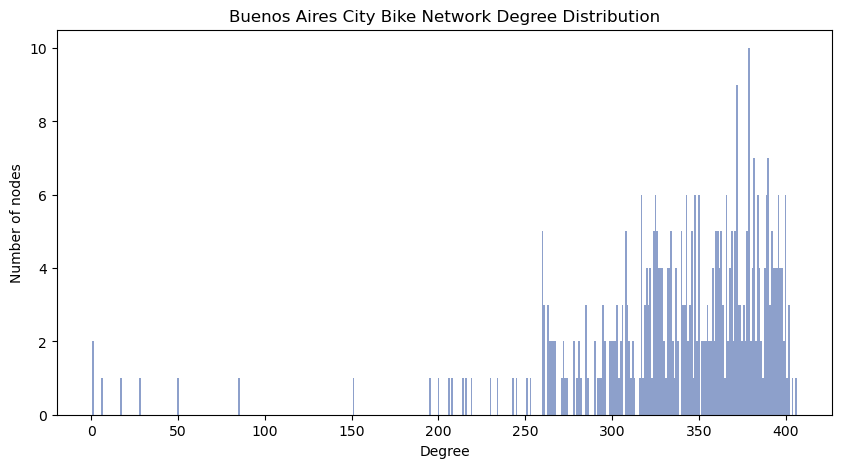

In [30]:
centralityDegreeDist(G2019)

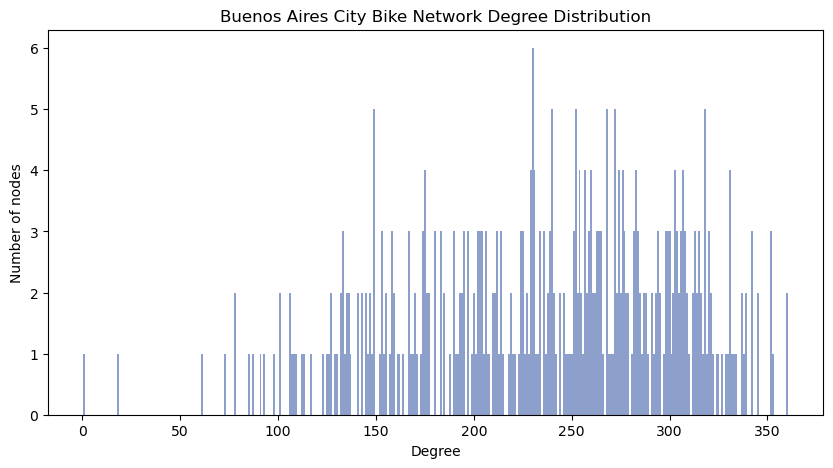

In [31]:
centralityDegreeDist(G2020)

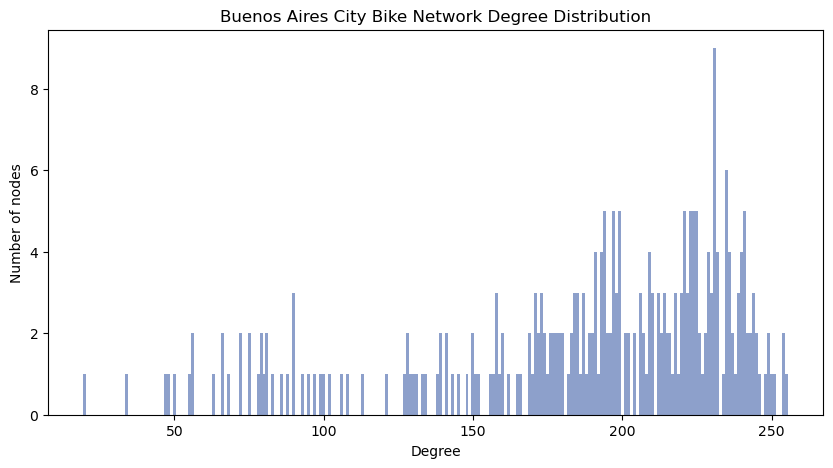

In [32]:
centralityDegreeDist(G2021)

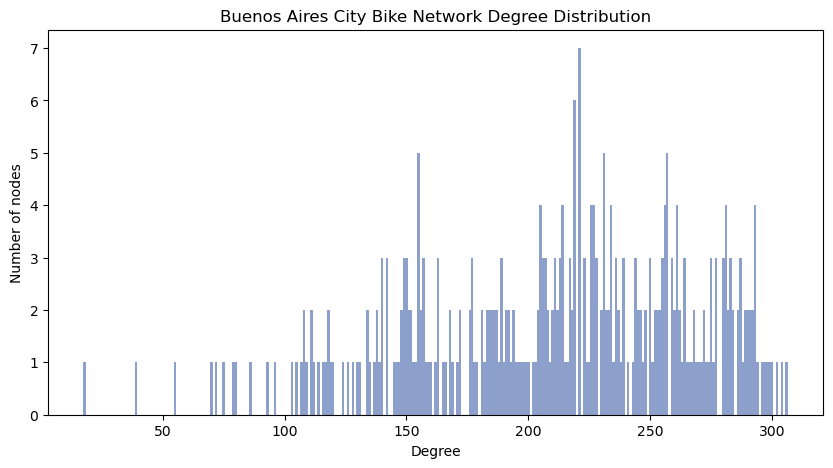

In [33]:
centralityDegreeDist(G2022)

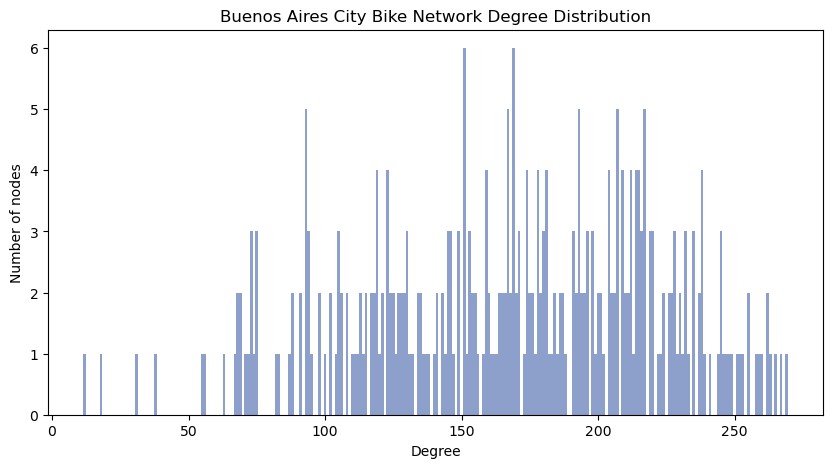

In [34]:
centralityDegreeDist(G2023)

As you can se above. Centrality degree has changed over the year.

- En 2019 encontramos el mayor numero nodos con alto numero de grado de centralidad y la mayoria se concentra entre 250 y 400
- In 2019 we find a major number of nodes with high number of degree within the center, and most are concentrated between 250 and 400.
- 
- En 2020 (lockdown) cambia en el grado de distribucion de los nodos. La mayoria se concentra entre 150 y 350 grados. Se ve claramente una reduccion en el numero de ejes entre nodos.
- En 2021 se reduce el numero de grados a 270 en comparacion a los años anteriores. El pico maximo de nodos con mayor numero de grados se reduce a una unidad. 
- En 2022 vuelve aumentar el numero de grados y los nodos con respecto al año anterior.
- En 2023 se observa una distribucion similar al año 2022. Hay un decaimiento en el numero de nodos y grados con respecto a este, pero es atribuible al hecho de que hasta la fecha no esta completa toda la informacion. 

In [22]:
# Degree
dd = sorted(nk.centrality.DegreeCentrality(G2019).run().scores(), reverse=True)
deg, cnt = np.unique(dd, return_counts=True)

In [24]:
df_station_degree = pd.DataFrame([(u, G2019.degree(u)) for u in G2019.iterNodes()], columns=['station_id', 'degree'])
df_station_degree = pd.merge(df_station_degree, df_bike_station, on=['station_id'], how='inner').sort_values('degree', ascending=False)
df_station_degree.head(10)

,station_id,degree,station_name
9,9,405,029 - Parque Centenario
30,30,404,014 - Pacifico
28,28,402,054 - Acuña de Figueroa
143,145,401,134 - SOLDADO DE LA FRONTERA
91,93,401,161 - Humahuaca
94,96,401,171 - Pasteur
7,7,401,025 - Plaza Guemes
41,41,401,104 - Federico Lacroze
0,0,400,005 - Plaza Italia
97,99,400,136 - Acevedo


In [76]:
df_station_degree = pd.DataFrame([(u, G2022.degree(u)) for u in G2022.iterNodes()], columns=['station_id', 'degree'])
df_station_degree = pd.merge(df_station_degree, df_bike_station, on=['station_id'], how='inner').sort_values('degree', ascending=False)
df_station_degree.head(10)

,station_id,degree,station_name
29,30,306,014 - Pacifico
89,99,304,136 - Acevedo
27,28,302,054 - Acuña de Figueroa
104,120,300,276 - PRIMERA JUNTA
9,9,299,029 - Parque Centenario
36,37,298,017 - Plaza Almagro
83,93,297,161 - Humahuaca
32,33,296,096 - Carlos Gardel
0,0,294,005 - Plaza Italia
248,342,293,100 - Plaza Gurruchaga


In [93]:
df_station_degree = pd.DataFrame([(u, G2023.degree(u)) for u in G2023.iterNodes()], columns=['station_id', 'degree'])
df_station_degree = pd.merge(df_station_degree, df_bike_station, on=['station_id'], how='inner').sort_values('degree', ascending=False)
df_station_degree.head(10)

,station_id,degree,station_name
29,30,269,014 - Pacifico
27,28,267,054 - Acuña de Figueroa
86,99,265,136 - Acevedo
0,0,263,005 - Plaza Italia
80,93,262,161 - Humahuaca
9,9,262,029 - Parque Centenario
315,443,260,142 - ARMENIA
161,212,259,255 - BARRANCAS DE BELGRANO
35,37,258,017 - Plaza Almagro
117,146,255,121 - YATAY


In [25]:
df_station_degree = pd.merge(df_station_degree, df_bike_station_geo, on=['station_id'], how='inner')


Lets see on the map the station degree of each bike station in 2023

In [27]:
with open( "config/station_degree_confmap.json") as f:
    config_map = json.load(f)
    
map_bike_trips = KeplerGl(height=600,  data={"Station Degree": df_station_degree}, config=config_map)
map_bike_trips

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'wbmbn57', 'type': …

The fact that stations like `014 - Pacifico`,  `054 - Acuña de Figueroa`, `136 - Acevedo` and `005 - Plaza Italia` are at the top of this list suggesting that a large number of citizens from different districts make regular trips to and from this station. This could potentially mean that these stations are either next to a large transportation hub or an important point of interest. Quick google search reveals that they are located across the street from a large educational institution and hospitals points. This explains both the regularity of the trips and the inflow of people from different suburban areas.



Now, lets calculate the degree In and Out of the stations, that will allow us to know which stations might require more replenishments or docks to support their supply and demand. By computing the degree of each vertex based on their incoming and outgoing edges, we are able to determine their ratio.

## Degree In: incoming/outgoing
A high in-out degree means that there are a lot more bikes parking here than going out, indicating a high supply of bikes. In other words, there may be a lack of docks.



High in-out ratios occur in three bike station (`161 - Humahuaca`, `029 - Parque Centenario` and `014 - Pacifico`), 


Pacifico : near Palermo railway and subway station. One of the hotspot of Buenos aires city.
Parque Centenario: close to Centenario Park and Angel Gallardo Subway station that is a halfway spot to this subway.

Humahuaca: near Medrano subway station and Corrientes Av. (where there are many shops and Cinemas)

From this simple analysis, it seems to be good for business in considerin the placement of more docks near these stations so that other users would not face the issue of not having enough docks to return the bikes.


Note: green path means incoming, whereas red means outgoing.

In [145]:
df_bike_trip_agg = df_bike_trip[df_bike_trip['year']==2023].groupby(['departure_station_id', 'return_station_id'])\
                                .agg({'departure_long':'min', 'departure_lat':'min', 'return_station_long':'min', 'return_station_lat':'min', 'rout_id': 'count'})\
                                .reset_index()

df_bike_trip_agg = df_bike_trip_agg.dropna()

df_bike_trip_agg = df_bike_trip_agg[df_bike_trip_agg['departure_station_id']!=df_bike_trip_agg['return_station_id'] ]

In [175]:
df_station_degree_in = pd.DataFrame([(u, G2023.degreeIn(u)) for u in G2023.iterNodes()], columns=['station_id', 'degree_in'])
df_station_degree_in = pd.merge(df_station_degree_in, df_bike_station, on=['station_id'], how='inner').sort_values('degree_in', ascending=False)
df_station_degree_in.head(10)

,station_id,degree_in,station_name
80,93,256,161 - Humahuaca
9,9,256,029 - Parque Centenario
29,30,253,014 - Pacifico
242,341,252,187 - Jose Maria Moreno
27,28,251,054 - Acuña de Figueroa
86,99,250,136 - Acevedo
161,212,250,255 - BARRANCAS DE BELGRANO
117,146,249,121 - YATAY
315,443,249,142 - ARMENIA
124,160,246,074 - INSTITUTO LELOIR


In [176]:
df_station_degree_in = pd.merge(df_station_degree_in, df_bike_station_geo, on=['station_id'], how='inner')
df_station_degree_in = pd.merge(df_bike_trip_agg, df_station_degree_in.iloc[:20,:] , left_on='return_station_id' , right_on='station_id', how='inner')

with open( "config/station_degree_in_confmap.json") as f:
    config_map = json.load(f)
    
map_bike_trips = KeplerGl(height=600,  data={"Station Degree": df_station_degree_in}, config=config_map)
map_bike_trips

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'jtlqnai', 'type': …


## 4.2. Degree Out: outgoing/incoming
A high out-in value means that there are a lot more bikes leaving here which could result in a shortage, indicating high demand for bikes. In other words, there may be a lack of bikes.

The highest out-in ratio belongs to `014 - Pacifico` that is on Santa Fe Av., close to Palermo rail and subway station. As we have seen before, this station is also the thirth with highest Degree In ratio, this means that maybe, there is a balance between outgoing and incoming bikes.


005 - Plaza Italia is one of the most outgoing bike station and it because is close to many important spot like Italia subway station, Italian Park and La Rural. This is a station to be wary of as there could be a shortage of bikes. 
It interesting to note that these station are mostly run off of bicycles and most of the time it is hard to get one. So it needs a biger supply of bikes to these stations.



In [177]:
df_station_degree_out = pd.DataFrame([(u, G2023.degreeOut(u)) for u in G2023.iterNodes()], columns=['station_id', 'degree_out'])
df_station_degree_out = pd.merge(df_station_degree_out, df_bike_station, on=['station_id'], how='inner').sort_values('degree_out', ascending=False)
df_station_degree_out.head(10)

,station_id,degree_out,station_name
29,30,269,014 - Pacifico
27,28,267,054 - Acuña de Figueroa
86,99,265,136 - Acevedo
0,0,263,005 - Plaza Italia
80,93,262,161 - Humahuaca
9,9,262,029 - Parque Centenario
315,443,260,142 - ARMENIA
161,212,259,255 - BARRANCAS DE BELGRANO
35,37,258,017 - Plaza Almagro
117,146,255,121 - YATAY


In [178]:

df_station_degree_out = pd.merge(df_station_degree_out, df_bike_station_geo, on=['station_id'], how='inner')
df_station_degree_out = pd.merge(df_bike_trip_agg, df_station_degree_out.iloc[:20,:] , left_on='departure_station_id' , right_on='station_id', how='inner')


with open( "config/station_degree_out_confmap.json") as f:
    config_map = json.load(f)
    
map_bike_trips = KeplerGl(height=600,  data={"Station Degree": df_station_degree_out}, config=config_map)
map_bike_trips

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'jtlqnai', 'type': …

# 5. Centrality 
## 5.1. Betweenness Centrality

The betweenness centrality is a measure of centrality in a graph based on shortest paths. For every pair of vertices in a connected graph, there exists at least one shortest path between the vertices such that either the number of edges that the path passes through (for unweighted graphs) or the sum of the weights of the edges (for weighted graphs) is minimized. The betweenness centrality for each vertex is the number of these shortest paths that pass through the vertex.

In a weighted network the links connecting the nodes are no longer treated as binary interactions, but are weighted in proportion to their capacity, influence, frequency, etc., which adds another dimension of heterogeneity within the network beyond the topological effects. A node’s strength in a weighted network is given by the sum of the weights of its adjacent edges.


The graph below illustrates the city bike stations by betweenness centrality.

In [ ]:
G2019.removeSelfLoops()
G2020.removeSelfLoops()
G2021.removeSelfLoops()
G2022.removeSelfLoops()
G2023.removeSelfLoops()

In [139]:
G2023.removeSelfLoops()

In [146]:
bc = nk.centrality.Betweenness(G2023)
bc.run()
df_betweeness_cent = pd.DataFrame(bc.ranking(), columns=['station_id', 'betweeness_centrality'])

df_betweeness_cent = pd.merge(df_betweeness_cent, df_bike_station, on=['station_id'], how='inner').sort_values('betweeness_centrality', ascending=False)
df_betweeness_cent = pd.merge(df_betweeness_cent, df_bike_station_geo, on=['station_id'], how='inner')

df_betweeness_cent.head(10)

,station_id,betweeness_centrality,station_name,lat,long
0,389,756.420966,269 - Plaza De La Misericordia,-34.631700,-58.455340
1,202,746.733344,275 - PLAZA 24 DE SEPTIEMBRE,-34.606984,-58.448540
2,434,701.945107,347 - CARABOBO,-34.626288,-58.455300
3,257,654.811370,229 - RIGLOS,-34.631018,-58.435056
4,70,638.957380,094 - GÚZMAN,-34.591511,-58.449652
5,446,621.429566,266 - PLAZA SABATTINI,-34.612296,-58.443295
6,228,615.527316,374 - Puan,-34.622092,-58.448547
7,225,572.436711,243 - PLAZOLETA CELEDONIO FLORES,-34.581576,-58.451530
8,407,570.478978,219 - Parque Chacabuco II,-34.636275,-58.444041
9,381,554.084573,231 - Margariños Cervantes,-34.610482,-58.474369


In [147]:
df_betweeness_cent = df_betweeness_cent.iloc[:20,:]
station_ids = df_betweeness_cent.station_id.unique().tolist()

In [148]:
df_bike_trip_agg = df_bike_trip_agg[df_bike_trip_agg['departure_station_id'].isin(station_ids) | df_bike_trip_agg['return_station_id'].isin(station_ids)]

In [149]:
with open( "config/station_betweenness_cent_confmap.json") as f:
    config_map = json.load(f)
    
map_bike_trips = KeplerGl(height=600,  data={"Betweenness Centrality": df_betweeness_cent, "Bike trips": df_bike_trip_agg}, config=config_map)
map_bike_trips

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'vh6j7v6', 'type': …

The nodes with the highest “betweenness centrality” are `Plaza de la Misericordia`, `Plaza 24 de Septiembre` and `Carabobo` bike station. As we can see from the graph above, most of this nodes are located in the middle of the city where they serve as a halfway between bikes station in the city center and those that are in the west. 

We might think that due to the demografic distribution of the city, traffic flows from the hotest point to other nodes which are mostly channelled through these station, but in reality, its hardly  happens that riders use these stations as a halfway point. Even Though, it might be a good idea to place more docks in these bike stations.



## Closeness Centrality

Closeness centrality indicates how close a node is to all other nodes in the network. It is calculated as inverse of the average of the shortest path length from the node to every other node in the network.



In [56]:
df_bike_trip_agg = df_bike_trip[df_bike_trip['year']==2023].groupby(['departure_station_id', 'return_station_id'])\
                                .agg({'departure_long':'min', 'departure_lat':'min', 'return_station_long':'min', 'return_station_lat':'min', 'rout_id': 'count'})\
                                .reset_index()

df_bike_trip_agg = df_bike_trip_agg.dropna()

df_bike_trip_agg = df_bike_trip_agg[df_bike_trip_agg['departure_station_id']!=df_bike_trip_agg['return_station_id'] ]


# Initialize algorithm
close = nk.centrality.Closeness(G2023, False, nk.centrality.ClosenessVariant.Generalized)
close.run()

#The most central nodes according to betweenness are then 
df_closeness_cent = pd.DataFrame(close.ranking(), columns=['station_id', 'closeness_centrality'])

df_closeness_cent = pd.merge(df_closeness_cent, df_bike_station, on=['station_id'], how='inner').sort_values('closeness_centrality', ascending=False)
df_closeness_cent = pd.merge(df_closeness_cent, df_bike_station_geo, on=['station_id'], how='inner')

df_closeness_cent.head(10)

,station_id,closeness_centrality,station_name,lat,long
0,202,0.549828,275 - PLAZA 24 DE SEPTIEMBRE,-34.606984,-58.448540
1,441,0.545145,208 - NICASIO OROÑO,-34.596744,-58.459403
2,87,0.544218,089 - Cabello,-34.582547,-58.405667
3,302,0.544218,383 - BOEDO Y VENEZUELA,-34.616354,-58.417074
4,446,0.544218,266 - PLAZA SABATTINI,-34.612296,-58.443295
5,421,0.543294,310 - FREIRE II,-34.575129,-58.452756
6,24,0.542373,031 - Padilla,-34.603343,-58.439521
7,256,0.542373,222 - SIMON BOLIVAR,-34.633528,-58.449379
8,381,0.542373,231 - Margariños Cervantes,-34.610482,-58.474369
9,275,0.541455,148 -La Paternal,-34.600831,-58.472127


In [62]:
df_closeness_cent = df_closeness_cent.iloc[:20,:]
station_ids = df_closeness_cent.station_id.unique().tolist()

df_bike_trip_agg = df_bike_trip_agg[df_bike_trip_agg['departure_station_id'].isin(station_ids) | df_bike_trip_agg['return_station_id'].isin(station_ids)]

with open( "config/station_closeness_cent_confmap.json") as f:
    config_map = json.load(f)
    
map_bike_trips = KeplerGl(height=600,  data={"Closeness Centrality": df_closeness_cent, "Bike trips": df_bike_trip_agg}, config=config_map)
map_bike_trips

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '493mhh8', 'type': …

Eigenvector Centrality and PageRank

Eigenvector centrality and its variant PageRank assign relative importance to nodes according to their connections, incorporating the idea that edges to high-scoring nodes contribute more. PageRank is a version of eigenvector centrality which introduces a damping factor, modeling a random web surfer which at some point stops following links and jumps to a random page. In PageRank theory, centrality is understood as the probability of such a web surfer to arrive on a certain page. Our implementation of both measures is based on parallel power iteration, a relatively simple eigensolver.

In [63]:
df_bike_trip_agg = df_bike_trip[df_bike_trip['year']==2023].groupby(['departure_station_id', 'return_station_id'])\
                                .agg({'departure_long':'min', 'departure_lat':'min', 'return_station_long':'min', 'return_station_lat':'min', 'rout_id': 'count'})\
                                .reset_index()

df_bike_trip_agg = df_bike_trip_agg.dropna()

df_bike_trip_agg = df_bike_trip_agg[df_bike_trip_agg['departure_station_id']!=df_bike_trip_agg['return_station_id'] ]


# Eigenvector centrality
ec = nk.centrality.EigenvectorCentrality(G2023)
ec.run()

df_eigenvector_cent = pd.DataFrame(ec.ranking(), columns=['station_id', 'eigenvector_centrality'])

df_eigenvector_cent = pd.merge(df_eigenvector_cent, df_bike_station, on=['station_id'], how='inner').sort_values('eigenvector_centrality', ascending=False)
df_eigenvector_cent = pd.merge(df_eigenvector_cent, df_bike_station_geo, on=['station_id'], how='inner')

df_eigenvector_cent.head(10)

,station_id,eigenvector_centrality,station_name,lat,long
0,100,0.192717,128 - PARQUE DEL BAJO,-34.605152,-58.368821
1,30,0.182790,014 - Pacifico,-34.577424,-58.426387
2,12,0.176517,147 - Constitución,-34.626851,-58.380707
3,167,0.159104,160 - Godoy Cruz y Libertador,-34.572583,-58.420628
4,196,0.152327,152 - JULIETA LANTERI,-34.618164,-58.359631
5,17,0.150709,008 - Congreso,-34.609422,-58.389336
6,76,0.150667,150 - RODRIGO BUENO,-34.618755,-58.355465
7,92,0.147534,130 - RETIRO II,-34.591738,-58.374364
8,51,0.146660,001 - FACULTAD DE DERECHO,-34.583749,-58.390602
9,0,0.144923,005 - Plaza Italia,-34.580550,-58.420954


In [67]:
df_eigenvector_cent = df_eigenvector_cent.iloc[:20,:]
station_ids = df_eigenvector_cent.station_id.unique().tolist()

df_bike_trip_agg = df_bike_trip_agg[df_bike_trip_agg['departure_station_id'].isin(station_ids) | df_bike_trip_agg['return_station_id'].isin(station_ids)]

with open( "config/station_eigenvector_cent_confmap.json") as f:
    config_map = json.load(f)
    
map_bike_trips = KeplerGl(height=600,  data={"Eigenvector Centrality": df_eigenvector_cent, "Bike trips": df_bike_trip_agg}, config=config_map)
map_bike_trips

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'dh9bh5', 'type': '…

In [68]:
# PageRank
pr = nk.centrality.PageRank(G2023, 1e-6)
pr.run()

df_pagerank_cent = pd.DataFrame(pr.ranking(), columns=['station_id', 'pagerank_centrality'])

df_pagerank_cent = pd.merge(df_pagerank_cent, df_bike_station, on=['station_id'], how='inner').sort_values('pagerank_centrality', ascending=False)
df_pagerank_cent.head(10)

,station_id,pagerank_centrality,station_name
0,12,0.003115,147 - Constitución
1,30,0.003115,014 - Pacifico
2,226,0.003115,281 - Villa Urquiza
3,212,0.003115,255 - BARRANCAS DE BELGRANO
4,399,0.003115,352 - San Jose de Flores
5,17,0.003115,008 - Congreso
6,0,0.003115,005 - Plaza Italia
7,353,0.003115,207 - PLAZA ARENALES
8,337,0.003115,396 - PLAZA ALBERTI
9,100,0.003115,128 - PARQUE DEL BAJO


### Community Detection
This section demonstrates the community detection capabilities of NetworKit. Community detection is concerned with identifying groups of nodes which are significantly more densely connected to eachother than to the rest of the network.

Code for community detection is contained in the community module. The module provides a top-level function to quickly perform community detection with a suitable algorithm and print some stats about the result.



In [71]:
G2023 = bikeGraph(df_bike_trip, 2023, weight='count', directed=False)
print("Year: 2023")
print("Number of nodes: ", G2023.numberOfNodes(), " - Number of edges: ", G2023.numberOfEdges(), " - Number of self loops: ", G2023.numberOfSelfLoops())

Year: 2023
Number of nodes:  321  - Number of edges:  54069  - Number of self loops:  320


In [72]:
# Choose and initialize algorithm
plmCommunities = nk.community.detectCommunities(G2023, algo=nk.community.PLM(G2023, True))

Communities detected in 0.00898 [s]
solution properties:
-------------------  -------------
# communities             5
min community size       43
max community size       91
avg. community size      64.2
imbalance                 1.4
edge cut             322544
edge cut (portion)        5.96541
modularity                0.446604
-------------------  -------------


/Users/galissa/miniconda3/envs/graph/lib/python3.8/site-packages/networkit/stopwatch.py:49: UserWarning: networkit.Timer is deprecated, will be removed in future updates.
  warn("networkit.Timer is deprecated, will be removed in future updates.")


Each community is associated with a unique integer id, and each node is associated to a community id. plpCommunityIDs is a set that contains all the community ids, while plpCommunities is a vector of size n (number of nodes of the graph) that contains the community id of each node (for example, use c = plpCommunities[v] to store in c the community id of node v).

In [105]:
# Creating an instance of PLP and running the algorithm.
# Use community.PLM(g) to run the PLM algorithm.
plp = nk.community.PLP(G2023, baseClustering=plmCommunities).run()

# Getting the Partition object.
plpPartition = plp.getPartition()

# Getting the community IDs.
plpCommunityIDs = plpPartition.getSubsetIds()

# Getting the community ID of each node of the graph g.
plpCommunities = plpPartition.getVector()

In [106]:
plpCommunityIDs

{0, 1, 2, 3, 4}

In [107]:
np.unique(plpCommunities, return_counts=True)

(array([0.00000000e+00, 1.00000000e+00, 2.00000000e+00, 3.00000000e+00,
        4.00000000e+00, 1.84467441e+19]),
 array([ 57,  55,  43,  91,  75, 128]))

In [108]:
print("{0} elements assigned to {1} subsets".format(plmCommunities.numberOfElements(),
                                                    plmCommunities.numberOfSubsets()))

449 elements assigned to 5 subsets


In [109]:
print("the biggest subset has size {0}".format(max(plmCommunities.subsetSizes())))

the biggest subset has size 91


In [114]:
plpCommunities.__len__() - 128

321

In [153]:

nodes = []
plp_comm = []
for u in G2023.iterNodes():
    nodes.append(u)
    plp_comm.append(plpCommunities[u])

df_plp_communities = pd.DataFrame({"station_id": nodes, "plp_communitie": plp_comm})

In [155]:
df_bike_trip_agg = df_bike_trip[df_bike_trip['year']==2023].groupby(['departure_station_id', 'return_station_id'])\
                                .agg({'departure_long':'min', 'departure_lat':'min', 'return_station_long':'min', 'return_station_lat':'min', 'rout_id': 'count'})\
                                .reset_index()

df_bike_trip_agg = df_bike_trip_agg.dropna()

df_bike_trip_agg = df_bike_trip_agg[df_bike_trip_agg['departure_station_id']!=df_bike_trip_agg['return_station_id'] ]


df_bike_trip_agg = pd.merge(df_bike_trip_agg, df_plp_communities, left_on='departure_station_id', right_on='station_id', how='left')
df_bike_trip_agg = pd.merge(df_bike_trip_agg, df_plp_communities, left_on='return_station_id', right_on='station_id', how='left')
df_bike_trip_agg['plp_communitie'] = np.where(df_bike_trip_agg['plp_communitie_x']==df_bike_trip_agg['plp_communitie_y'], df_bike_trip_agg['plp_communitie_x'], -1)

df_bike_trip_agg=df_bike_trip_agg[['departure_station_id', 'return_station_id', 'departure_long',
       'departure_lat', 'return_station_long', 'return_station_lat', 'rout_id',
       'plp_communitie']]

In [167]:
with open( "config/trip_communities_confmap.json") as f:
    config_map = json.load(f)
    
map_bike_trips = KeplerGl(height=600,  data={"PLP Communities": df_bike_trip_agg}, config=config_map)
map_bike_trips

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'uh0ijun', 'type': …

Being that buenos aires city is such a big area you will find that the areas in which people travel are within 4 specific zones 

# Conclusion
Understanding the data is an important step for the business to gain insights into their operations and make data-driven decisions to achieve their business objectives. Data which requires geolocation often needs to be visualised in graphs to better understand how the nodes and edges are relative to and interact with one another.
For instance, in this tutorial, the business we were able to explore the trips and customers behaviour, and from there understand which are the more frequently bike stations. This was helpful in providing insights into the way Baywheels can manage their inventory.
The analysis done above happens on LynxKite which has just been made free and accessible for anyone to try! There are other tutorials available on their website which are easy to follow. As a drag and drop platform, the learning curve is gentle and easy to pick up. Save yourself precious time from writing code to plotting graphs when you can pull and have the platform do a variety of graphing analysis and visualisations for you! Check out our second article if you want to know how we put these analyses together on LynxKite.